In [20]:
# Import packages
import os
import re
import PyPDF2
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.probability import FreqDist
import stanza
from textblob import TextBlob
from textblob import Word
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
stanza.download('en',verbose=False) # Load the English POS tagging model from Stanza

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lenne\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
# Download the pdfs from our S3 bucket
#import requests
#
#url = 'https://mda-georgia-bucket.s3.eu-central-1.amazonaws.com/Articles/article10.pdf'
#
#response = requests.get(url)
#with open('local_file.pdf', 'wb') as f:
#    f.write(response.content)
#print('PDF file downloaded successfully.')

In [36]:
def extract_text_from_pdf(file_path):
    if not os.path.exists(file_path):
        print("File not found:", file_path)
        return ""

    try:
        with open(file_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            num_pages = len(pdf_reader.pages)
            text = ""

            for page_number in range(num_pages):
                page = pdf_reader.pages[page_number]
                text += page.extract_text()

        # Remove linebreaks
        text = text.replace('\n', ' ')

        return text
    except Exception as e:
        print("Error occurred while extracting text:", str(e))
        return ""



# Define a function to preprocess the text
def preprocess_text(text, extra_stop_words=[]):
    # Remove noise, white spaces, and punctuation using regular expressions
    text = re.sub(r'\s+', ' ', text)  # Remove extra white spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d', '', text)  # Remove numbers

    # Tokenization
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    # Add extra stopwords
    stop_words.update(extra_stop_words)  
    # stop_words.update(["noise"]) # not sure whether or not to put noise as a stopword
    tokens = [token for token in tokens if token not in stop_words]

    # Remove tokens containing numbers or the word "http", remove stopwords, remove tokens of length <=2
    tokens = [token for token in tokens if not any(char.isdigit() for char in token)
              and "http" not in token and "www" not in token and token.lower() not in stop_words
              and not (len(token) <= 2)]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    stop_words.update(["study"]) # this can only be added here to the stop words or it will still appear in the results (because can be noun, verb, ...)
    tokens = [token for token in tokens if token not in stop_words]

    return tokens


# Define a function to perform part of speech tagging     # THIS FUNCTION GIVES BAD RESULTS, a lot of words are incorrectly labeled
#def pos_tagging(tokens):
#    nlp = stanza.Pipeline('en', processors='tokenize, mwt, pos') # POSProcessor requires the TokenizeProcessor and MWTProcessor in the pipeline
#
#   # Perform POS tagging with Stanza on each token
#   doc = nlp(' '.join(tokens))
#   tagged_tokens = [(word.text, word.upos) for sent in doc.sentences for word in sent.words]
#
#    # Split the tagged tokens into the ones without and with "X" as POS tag (= words that don't fit into a category)
#    filtered_tagged_tokens = [(token, pos) for token, pos in tagged_tokens if pos != 'X']
#    x_tagged_tokens = [(token, pos) for token, pos in tagged_tokens if pos == 'X']
#
#    # Print the tokens with POS tag 'X'
#    print("\nTokens with POS tag 'X' that are now removed:")
#    for token, pos in x_tagged_tokens:
#        print(token, pos)
#    
#    return filtered_tagged_tokens


# Define a function to extract bag of words and 2-grams
def extract_bag_of_words(tokens):
    # Bag of Words
    word_freq = FreqDist(tokens)
    most_common_words = word_freq.most_common()

    # 2-grams
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    n_gram_scores = finder.score_ngrams(bigram_measures.raw_freq)
    most_common_2grams = sorted(n_gram_scores, key=lambda x: x[1], reverse=True)

    return most_common_words, most_common_2grams


# Named entity recognition with Stanza
def ner_extraction(common_words_list):
    # Extract the 1000 most frequent words from the bag_of_words results ((extra) stopwords don't occur in these results)
    common_words = [word for word, _ in common_words_list[:1000]]  # Extract only the words and not the frequencies

    text = ' '.join(common_words)  # Convert preprocessed tokens back to text
    nlp = stanza.Pipeline(lang='en', processors='tokenize, ner', verbose=False)
    doc = nlp(text)
    entities = [(ent.text, ent.type) for sent in doc.sentences for ent in sent.ents]
    return entities


# Define a function to summarize the text with sentences that contain many common words
def text_summarization(text, common_words_list, extra_stopwords=[]): #possibility to add words that may not appear in the selected sentences; default of extra stopwords is empty
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    # Extract the 10 most frequent words from the bag_of_words results ((extra) stopwords don't occur in these results)
    common_words = [word for word, _ in common_words_list[:10]]  # Extract only the words and not the frequencies

    # Select short sentences that contain the most frequent words
    selected_sentences = []
    for sentence in sentences:
        sentence_tokens = [token.lower() for token in word_tokenize(sentence)]  # Convert tokens to lowercase
        common_words_count = sum(1 for token in sentence_tokens if token in common_words)
        if common_words_count >= 6 and not any(word in sentence_tokens for word in extra_stopwords): #extra_stopwords may NOT appear in the sentence, default stopwords are allowed
            selected_sentences.append(sentence)

    # Check if any selected sentences were found
    if len(selected_sentences) == 0:
        print("No sentences found where common words occur more than once.")

    return selected_sentences


# Define a function to summarize the text by extracting the 5 most common nouns using TextBlob
def extract_common_nouns(text, num_nouns=5):
    blob = TextBlob(text)

    # Gather words
    nouns = list()
    for word, tag in blob.tags:
        if tag == 'NN':
            nouns.append(word.lemmatize())

    # Calculate word frequencies
    word_freq = FreqDist(nouns)
    most_common_nouns = word_freq.most_common(num_nouns)

    extracted_nouns = []
    for noun, frequency in most_common_nouns:
        word = Word(noun)
        extracted_nouns.append(word)

    return extracted_nouns


# Define a function for sentiment analysis
def sentiment_analysis(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores


# Define a function to generate a word cloud
def generate_word_cloud(tokens, max_words=20):
    text = ' '.join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


# Define a function for topic modelling (Latent Dirichlet Allocation)
def latent_dirichlet_allocation(tokens, num_topics=3):
    if len(tokens) == 0:
        print("No tokens available for topic modeling.")
        return []

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([' '.join(tokens)])

    if len(vectorizer.get_feature_names()) == 0:
        print("Empty vocabulary. The documents may only contain stop words.")
        return []

    feature_names = vectorizer.get_feature_names()

    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    topic_keywords = []
    for topic_idx, topic in enumerate(lda.components_):
        top_indices = topic.argsort()[:-11:-1]
        topic_keywords.append([feature_names[i] for i in top_indices])

    return topic_keywords

Processed all files
Most common words: [('noise', 2850), ('level', 739), ('health', 713), ('effect', 652), ('sound', 528), ('exposure', 522), ('pollution', 454), ('environmental', 384), ('frequency', 313), ('traffic', 292), ('acoustic', 277), ('sleep', 266), ('dba', 255), ('source', 253), ('response', 249)]
Most common 2-grams: [(('noise', 'pollution'), 0.0041012889765354825), (('noise', 'level'), 0.003358198290891423), (('noise', 'exposure'), 0.0025579467832747434), (('low', 'frequency'), 0.0019577581525622337), (('effect', 'noise'), 0.0019148875360827688), (('public', 'health'), 0.001686244248192289), (('environmental', 'noise'), 0.001643373631712824), (('air', 'pollution'), 0.001571922604247049), (('sound', 'pressure'), 0.001457600960301809), (('pressure', 'level'), 0.0013289891108634142), (('hearing', 'loss'), 0.0012432478779044842), (('traffic', 'noise'), 0.0012146674669181743), (('frequency', 'noise'), 0.0012003772614250193), (('sleep', 'disturbance'), 0.0011717968504387094), (('

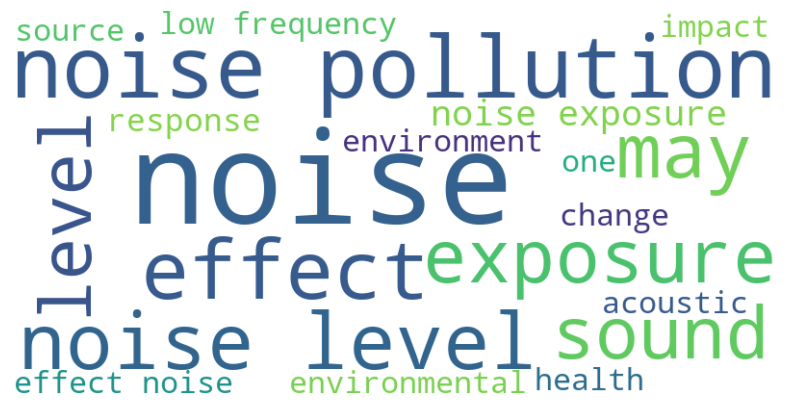

37 selected sentences: ['The effects of noise pollution on  health may be the direct consequence of exposure to noise or may be attenuated by reac-tions to noise, such as annoyance or unhappiness (10).', 'Health Effects of Noise Pollution Auditory Health Effects of Noise Pollution 1.Tinnitus is an abnormal ringing sound arising mainly in- side the body.', 'Health Effects of Industrial Noise Pollution   Since sound does not become ‘noise’ until it reaches and is  appreciated by a person, it was important to consider the  subjective effect of noise.', ')Published by : www.ijert.org 433Table 6: Effects of noise pollution on public health and welfare  Effect of noise Protective  noise limit  (LAeq, 24h,  dBA) Duration of  exposure  (Years) Measured noise level in various industries (LAeq, 8h, dBA )/Inference (level  of risk)     Grain mills Metal Plastic Wood Non-formal  Metal  Noise Induced Hearing Loss  (NIHL) 70 20-40 94.4/Very  High risk 90.2/Very  High risk 83.2/High  risk 82.1/High  

In [37]:
# Get the folder_path where the file is in (= current working directory)
folder_path = os.getcwd()


# Concatenate all article texts together
concatenated_text = "" # initialize empty variable to store the concatenated_text in
for file_name in os.listdir(folder_path):
    if file_name.endswith(".pdf"):
        file_path = os.path.join(folder_path, file_name)
        text = extract_text_from_pdf(file_path)
        concatenated_text += text

# Define extra stop words: "et", "al", "accessed" and months to stopwords (to remove "accessed {monthname}"), ...
extra_stop_words = ["et", "al", "doi", "vol", "accessed", "table", "keywords", "model", "research", "may",
                    "downloaded", "guest", "bcn", "patient", "cluster", "model", "used", "results", "data", "analysis", "table", "value", "contents", "randomizations", "methods", "measurement"]

# Apply NLP to the concatenated text
preprocessed_text = preprocess_text(concatenated_text, extra_stop_words)
#tagged_tokens = pos_tagging(preprocessed_text)
most_common_words, most_common_2grams = extract_bag_of_words(preprocessed_text)
named_entities = ner_extraction(most_common_words)
selected_sentences = text_summarization(concatenated_text, most_common_words, extra_stop_words)
sentiment_scores = sentiment_analysis(concatenated_text)
#topic_keywords_3 = latent_dirichlet_allocation(preprocessed_text)
#topic_keywords_1 = latent_dirichlet_allocation(preprocessed_text, num_topics=1)


# Print the results
print("Processed all files")
print("Most common words:", most_common_words[:15])
print("Most common 2-grams:", most_common_2grams[:30])
print("Named entities:", named_entities) # not giving any interesting results
generate_word_cloud(preprocessed_text)
print(f"{len(selected_sentences)} selected sentences:", selected_sentences)
print("Sentiment scores:", sentiment_scores)
#print("Topic keywords:", topic_keywords_3)
#print("Topic keywords:", topic_keywords_1)


In [38]:
# get an error above: debug by seeing if everything works for article 1
current_dir = os.getcwd()

# Specify the PDF file name
pdf_file_name = "Article3.pdf"

# Construct the full path to the PDF file
pdf_file_path = os.path.join(current_dir, pdf_file_name)

text = extract_text_from_pdf(pdf_file_path)
print(text)

 Jundishapur J Health Sci. 2015 January; 7(1): e25357. DOI: 10.5812/jjhs.25357   Published online 2015 January 20.  Research Article     Noise Pollution and Health Eﬀects   Sahar Geravandi  1 ; Afshin Takdastan  2 ; Elahe Zallaghi  3 ; Mehdi Vousoghi Niri  4 ; Mohammad  Javad Mohammadi  4,* ; Hamed Saki  4 ; Abolfazl Naiemabadi  4     1 Department of Nursing, Tehran Medical Sciences Branch, Islamic Azad University , Tehran, IR Iran  2 Environmental Technologies Research Center, Department of Environmental Health Engineering, Health Faculty , Ahvaz Jundishapur University of Medical Sciences, Ahvaz, IR Iran  3 Department of Environmental, Khouzestan Sciences and Research, Islamic Azad University , Ahvaz, IR Iran  4 Department of Environmental Health Engineering, Health Faculty , Ahvaz Jundishapur University of Medical Sciences, Ahvaz, IR Ir an    *Corresponding author  : Mohammad Javad Mohammadi, Department of Environmental Health Engineering, Health Faculty , Ahvaz Jundishapur Universit

In [43]:
blob = TextBlob(text)

# Gather words
nouns = list()
for word, tag in blob.tags:
    if tag == 'NN':
        nouns.append(word.lemmatize())

# Calculate word frequencies
word_freq = FreqDist(nouns)
# Get the 5 most common nouns
most_common_nouns = word_freq.most_common(5)

print('These articles are about:')
for noun, frequency in most_common_nouns:
    word = Word(noun)
    print(word)

These articles are about:
noise
study
pollution
health
traﬃc


In [30]:
extra_stop_words = ["et", "al", "doi", "vol", "accessed", "january", "february", "march", "april", "may", "june", "august", "september", "october", "november", "december", "table", "keywords", "model", "research", 
                    "downloaded", "guest", "bcn", "patient", "cluster", "model", "used", "results", "data", "analysis", "table", "value", "contents", "randomizations", "methods", "measurement", "ahvaz"]

preprocessed_text = preprocess_text(text) #, extra_stop_words
preprocessed_text[:50]

['jundishapur',
 'health',
 'sci',
 'jjhs',
 'published',
 'online',
 'article',
 'noise',
 'pollution',
 'health',
 'eﬀects',
 'sahar',
 'geravandi',
 'afshin',
 'takdastan',
 'elahe',
 'zallaghi',
 'mehdi',
 'vousoghi',
 'niri',
 'mohammad',
 'javad',
 'mohammadi',
 'hamed',
 'saki',
 'abolfazl',
 'naiemabadi',
 'department',
 'nursing',
 'tehran',
 'medical',
 'science',
 'branch',
 'islamic',
 'azad',
 'university',
 'tehran',
 'iran',
 'environmental',
 'technology',
 'center',
 'department',
 'environmental',
 'health',
 'engineering',
 'health',
 'faculty',
 'jundishapur',
 'university',
 'medical']

In [31]:
most_common_words, most_common_2grams = extract_bag_of_words(preprocessed_text)
print(most_common_words[:10])
print(most_common_2grams[:10])

[('noise', 107), ('health', 52), ('level', 35), ('traﬃc', 32), ('pollution', 31), ('eﬀects', 29), ('sound', 23), ('road', 18), ('roadway', 18), ('pressure', 17)]
[(('noise', 'pollution'), 0.014492753623188406), (('health', 'eﬀects'), 0.00947603121516165), (('traﬃc', 'noise'), 0.008918617614269788), (('road', 'traﬃc'), 0.008361204013377926), (('sound', 'pressure'), 0.008361204013377926), (('pressure', 'level'), 0.007803790412486065), (('noise', 'level'), 0.005016722408026756), (('myocardial', 'infarction'), 0.004459308807134894), (('sleep', 'quality'), 0.004459308807134894), (('noise', 'health'), 0.0039018952062430325)]


In [32]:
entities = ner_extraction(most_common_words)
entities

[('one', 'CARDINAL')]

In [ ]:
# make sure that the preprocessing of the words is added here too, tokenize the words back to sentences if it's possible (for this part)
selected_sentences = text_summarization(text, most_common_words)
selected_sentences

In [ ]:
sentiment_scores = sentiment_analysis(text)
sentiment_scores

In [ ]:
# here is a problem
topic_keywords = latent_dirichlet_allocation(preprocessed_text, num_topics=5)

In [ ]:
generate_word_cloud(preprocessed_text)

In [ ]:
    word_freq = FreqDist(preprocessed_text)
    most_common_words = [word for word, _ in word_freq.most_common(10)]
most_common_words

In [19]:
# OLD VERSION
# Define a function for text summarization
def text_summarization(text):
    sentences = sent_tokenize(text)

    # Extract the most frequent words
    tokens = word_tokenize(text)
    word_freq = FreqDist(tokens)
    most_common_words = [word for word, _ in word_freq.most_common(10)]

    # Select short sentences that contain the most frequent words
    selected_sentences = []
    for sentence in sentences:
        sentence_tokens = word_tokenize(sentence)
        common_words_count = sum(1 for token in sentence_tokens if token in most_common_words)
        if common_words_count >= 3:
            selected_sentences.append(sentence)

    return selected_sentences

In [ ]:
def ner_extraction(text):
    nlp = stanza.Pipeline(lang='en', processors='tokenize,ner', verbose=False)

    # Perform NER with Stanza on the text
    doc = nlp(text)
    
    # Extract named entities from the document
    named_entities = [(ent.text, ent.type) for sent in doc.sentences for ent in sent.ents]
    
    return named_entities

ner_extraction(text) 